In [12]:
import xarray as xr
import geopandas as gpd
import numpy as np
import rasterio
from rasterio import features
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import regionmask
import pandas as pd

In [2]:
ds = xr.load_dataset('fault_data/wglc_timeseries_30m_daily.nc')
density = ds['density']
density

<xarray.DataArray 'density' (time: 5479, lat: 360, lon: 720)> Size: 6GB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 44kB 2010-01-01 2010-01-02 ... 2024-12-31
Attributes:
    long_name:     frequency of lightning strokes per unit area
    units:         strokes km-2 d-1
    actual_range:  [ 0.       13.095334]

In [3]:
dno_shapes = gpd.read_file('../shapes_and_masks/DNOs/DNO_License_Areas_20240503_latlon.shp')
dno_shapes

,geometry
0,"MULTIPOLYGON (((0.87474 51.51298, 0.87656 51.5..."
1,"POLYGON ((0.26688 52.81243, 0.26698 52.81218, ..."
2,"POLYGON ((-0.24419 51.48844, -0.24509 51.48926..."
3,"MULTIPOLYGON (((-4.25501 53.38796, -4.2556 53...."
4,"POLYGON ((-1.95899 53.21664, -1.95676 53.21383..."
5,"MULTIPOLYGON (((-1.59803 55.62683, -1.59864 55..."
6,"POLYGON ((-2.66162 55.14636, -2.65693 55.13614..."
7,"MULTIPOLYGON (((-5.11618 55.24121, -5.11946 55..."
8,"POLYGON ((0.56587 51.48862, 0.57284 51.48845, ..."
9,"MULTIPOLYGON (((-3.11357 51.37569, -3.11457 51..."


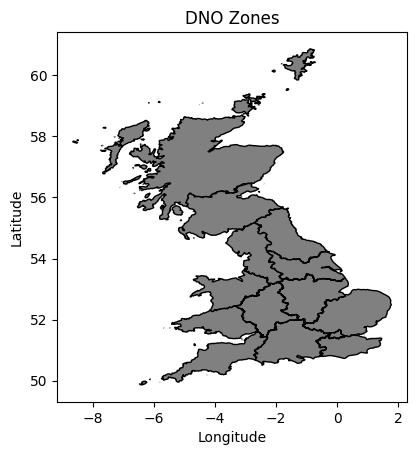

In [4]:
dno_shapes.plot(color="grey", edgecolor="black", linewidth=1)
plt.title("DNO Zones")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [5]:
weights = np.cos(np.deg2rad(density['lat']))
weights = weights / weights.mean()  # normalise
weights = xr.DataArray(weights, dims=['lat'])

In [6]:
check = density.sel(lat=slice(40,70),lon=slice(-5,15),time=slice('01-04-2024','31-12-2024'))
check = check/check.max('time')

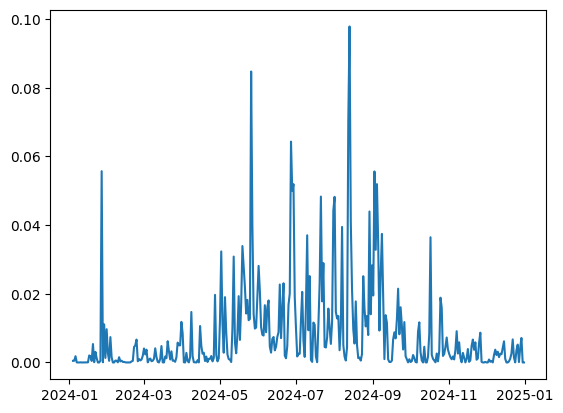

In [7]:
plt.plot(check.time,check.mean(('lat','lon')))

In [10]:
regions = regionmask.Regions(
    outlines=dno_shapes.geometry.values,
    names=dno_shapes.index.astype(str),
    numbers=list(range(len(dno_shapes)))
)
# Apply regionmask to your data's grid
region_mask = regions.mask(density)


In [11]:
region_means = []
for i in range(len(dno_shapes)):
    mask_i = region_mask == i
    masked_density = density.where(mask_i)
    masked_weights = weights.where(mask_i)

    weighted_mean = (masked_density * masked_weights).sum(dim=["lat", "lon"]) / masked_weights.where(~np.isnan(masked_density)).sum(dim=["lat", "lon"])
    region_means.append(weighted_mean)

In [14]:
time_series_df = pd.DataFrame(
    {str(dno_shapes.index[i]): region_means[i].values for i in range(len(dno_shapes))},
    index=density["time"].values
)


In [15]:
time_series_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
2010-01-01,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.000353,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-02,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-03,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-04,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-05,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2024-12-28,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2024-12-29,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2024-12-30,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
last_year = time_series_df[time_series_df.index >= '2024-04-01']
last_year

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
2024-04-01,0.000000,0.000388,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000146,0.002178,0.0,0.000000
2024-04-02,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2024-04-03,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2024-04-04,0.000575,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000131,0.000218,0.000000,0.0,0.000458
2024-04-05,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2024-12-28,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2024-12-29,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2024-12-30,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000


In [28]:
last_year = last_year.rename(columns = {
    "0": 'East England',
    "1": 'East Midlands',
    "2": 'London',
    "3": 'North, Wales, Merseyside and Cheshire',
    "4": 'West Midlands',
    "5": 'North East England',
    "6": 'North West England',
    "7": 'North Scotland',
    "8": 'South East England',
    "9": 'South Wales',
    "10": 'South West England',
    "11": 'Yorkshire',
    "12": 'South and Central Scotland',
    "13": 'Southern England'
    }
)

In [29]:
last_year

,East England,East Midlands,London,"North, Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
2024-04-01,0.000000,0.000388,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000146,0.002178,0.0,0.000000
2024-04-02,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2024-04-03,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2024-04-04,0.000575,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000131,0.000218,0.000000,0.0,0.000458
2024-04-05,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2024-12-28,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2024-12-29,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2024-12-30,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000


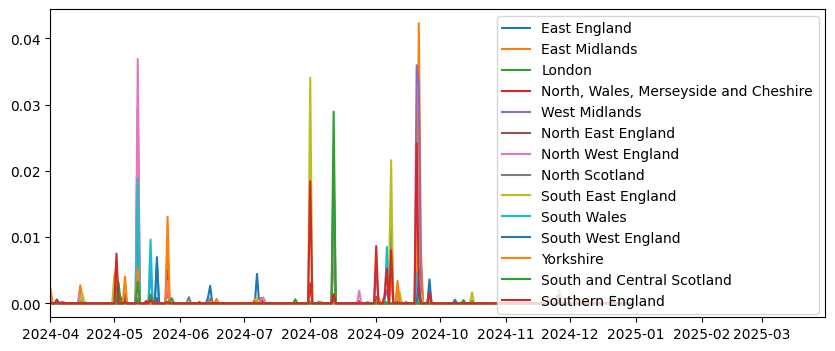

In [44]:
plt.figure(figsize=(10,4))
for p in last_year:
    plt.plot(last_year.index,last_year[p],label=p)
plt.xlim(pd.to_datetime('2024-04-01'),pd.to_datetime('2025-03-31'))
plt.legend(loc='upper right')
plt.show()

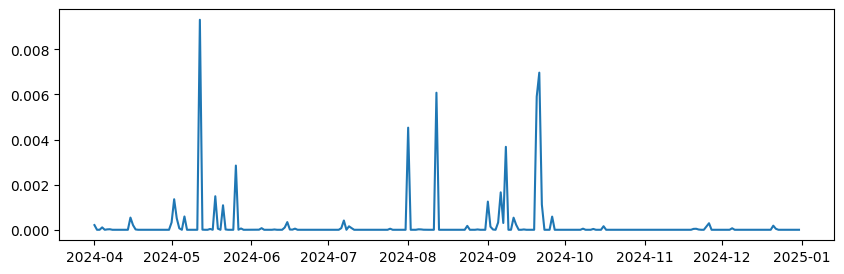

In [38]:
uk_mean = last_year.mean(axis=1)
plt.figure(figsize=(10,3))
plt.plot(uk_mean.index,uk_mean)
plt.show()

In [39]:
last_year.to_csv('../saved_dfs/lightning_density_timeseries_DNO_areas_Apr_2024-Dec_2024.csv')